In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# __TUNING AF K_MELT MED GENNEMSNITSREFERENCE__ 

## __Indlæsning af data__

Al data indlæses og slices præcis, som vi har gjort tidligere.

Indlæsning af DMI-data:

In [4]:
rådata = pd.read_excel('Ægte_DailyMinMax_Ilullisat_Cor-2.xlsx')
print(rådata)
data = rådata.to_numpy()
år_rå, temp_rå = data[:,0], data[:,1]

               Yr       Temp  Completeness
0       1873.0000 -20.131622             2
1       1873.0014 -12.826645             2
2       1873.0027 -20.587018             2
3       1873.0041 -12.755726             2
4       1873.0055 -21.348169             2
...           ...        ...           ...
108109  2020.9932  -3.317742             0
108110  2020.9945  -4.417742             0
108111  2020.9959   1.182258             0
108112  2020.9973   0.000000             0
108113  2020.9986   0.000000             0

[108114 rows x 3 columns]


### Interpolering af DMI-data

Med henblik på at få opløsningen af DMI-dataen op på 4 punkter pr. døgn, interpoleres data i cellen herunder. Fordi vi gerne vil beholde de datapunkter, der er, men indskyde et datapunkt midt imellem hvert tidsskridt, defineres en funktion, som først tager alle 'naboindgange' i tidsarrayet, og finder gennemsnittet af dem (dette svarer til alle punkterne mellem DMI-dataen). Herefter laves en ny list, hvor der skiftevis tilføjes et datapunkt, og et mellempunkt, så vi ender med en lang liste, som både indeholder de 'rigtige' årstal, og de interpolerede. Herefter interpoleres temperaturene, så der kommer en temperaturværdi til hver af tidspunkterne i listen 'år'.

In [5]:
def interpolation_år():
    interpol_år = []
    år = []
    temp = []
    for i in range(1, len(år_rå)):      # Finder mellempunkter for årsarrayet
        punkt = (år_rå[i] + år_rå[i-1])/2
        interpol_år.append(punkt)

    for i in range(len(interpol_år)):   # Laver liste med både DMI-årstal og mellempunkter
        år.append(år_rå[i])
        år.append(interpol_år[i])
    år.append(år_rå[-1])   # Tilføjer det sidste rå datapunkt manuelt, da der et ét råt datapunkt mere end mellempunkterne.
    return np.array([år])
    
år = interpolation_år()      # Interpolerer temperaturdataen

temp = np.interp(år, år_rå, temp_rå)


Indlæsning af GRACE-data

In [6]:
råsatellit = pd.read_csv('greenland_mass_200204_202311.txt', delimiter = '\s+', header = None, skiprows = lambda x: x < 31)
satellit = råsatellit.to_numpy()
år_sat, dmasse_sat = satellit[:, 0], satellit[:, 1]
densitet_is = 917
dvol_sat = 10**12 * dmasse_sat/densitet_is   # Vi omregner massetilvækst til volumentilvækst
V_sat_err = 10**12 * abs(1/densitet_is * satellit[:,2])

Data slices, sådan at vi kun benytter de år, hvor der er overlap mellem de to datasæt. Vær opmærksom på, at jeg for at undgå for mange variabelnavne genbruger navnene fra rådata.

In [7]:
# Slicing af DMI-data
top = max(år_sat)   
bund = min(år_sat)
temp = temp[(år <= top) & (år >= bund)] # Nyt temperatur-array, som kun indeholder temperaturer for samme årrække som satellitdata
år = år[(år <= top) & (år >= bund)] # Sørger for, at vi også har et årstals-array med de tilsvarende indgange (samme maske)

# Slicing af GRACE-data
topDMI = max(år)
dmasse_sat = dmasse_sat[år_sat <= topDMI]
dvol_sat = dvol_sat[år_sat <= topDMI]
V_sat_err = V_sat_err[år_sat <= topDMI]
år_sat = år_sat[år_sat <= topDMI]

For at bestemme det gennemsnitlige årlige nedbør, som skal benyttes i simuleringen, hentes nedbørsdata.

In [8]:
råNGRIP = pd.read_excel('rådata NGRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 58, usecols = [0,1,2,3,4,5,6,7,8])
råGRIP = pd.read_excel('GRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 54, usecols = [0,1,2,3,4,5,6,7])

NGRIP, GRIP = råNGRIP.to_numpy(), råGRIP.to_numpy()
NGRIPakk0, GRIPakk0 = NGRIP[:, 6], GRIP[:, 5]
NGRIPår0, GRIPår0 = NGRIP[:, 1], GRIP[:, 1]

Gennemsnit af nedbør for GRIP og NGRIP over de seneste 20 år af dataserien bestemmes.

In [9]:
akk_list = (NGRIPakk0[1:21] + GRIPakk0[1:21])/2   # Tager ikke første punkt med grunden manglende nedbørsdata
akk_gns = np.mean(akk_list)
print('gns akkumulation = ', akk_gns)

gns akkumulation =  0.2034321448890318


## __Tuning af nedbørskonstant__

For at tune nedbørskonstanten, køres simuleringen med $k_{melt}$ og $k_{acc}$ lig 1. Undervejs summeres det samlede volumen nedbør hen over simuleringsperioden. Det bestemmes, hvor meget nedbør der er faldet pr. år, og dette resultat sammenlignes med tabelværdien på $642 \cdot 10^{12}$ kg årligt, og nedbørskonstanten bestemmes som den faktor, der skal ganges på nedbørsvoluminet fra simuleringen for, at få det korrekte årlige nedbør.

In [10]:
V_start = 2.85 * 10**15   # startvolumen af iskappe
V_sat = dvol_sat + V_start - dvol_sat[0]
V = V_start  # startvolumen af iskappe
V_0 = V_start 
V_sat = dvol_sat + V_0 - dvol_sat[0]
h = 3 * 10**3       # Starthøjde af iskappe
R = 500 * 10**3     # Startradius af iskappe
T_f = 0        
alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år

# Tuningskonstanter
# k_melt = 8.4 * 10**(-1)   # Smeltekonstanten (Det er denne, vi har varieret på for at få graferne til at overlappe)
# På et år smelter ca. 10 cm ned 
acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden
k_acc = 1   # Denne tuningskonstant kommer fra vores undervurdering af nedbøren. Den kan vi også tune på, hvis nødvendigt. 
k_melt = 1

# Der oprettes tomme lister til resultatet af simuleringen
V_list = []
V_melt_list = []
V_acc_list = []


for i in range(len(år)):
    R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
    
    V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
    
    if temp[i] - T_f <= 0:
        V_melt = 0
    elif temp[i] - T_f > 0:
        V_melt = k_melt * 8/3 * R * (temp[i] - T_f) * ((T_f - temp[i])/(alfa * k))**2 * dt  # ganger tidsskridt og M på
    V += V_acc - V_melt
    
    V_list.append(V)
    V_melt_list.append(V_melt)
    V_acc_list.append(V_acc)
    
V_sum = np.sum(V_acc_list)/(år[-1] - år[0])
V_forventet = (642 * 10**12)/(densitet_is) #m^3

k_acc = V_forventet/V_sum
print('k_acc =', k_acc)

k_acc = 2.255739076054341


## Tuning af $k_{melt}$

Funktion, som tager k-melt-værdi, og retunerer chi-kvadratet for simuleringen, defineres. Simuleringen kører som vi kender den. Værdierne fra simuleringen interpoleres, så der bliver én simuleringsværdi pr. GRACE-datapunkt, før der kan beregnes reduceret chi-kvadrat. Simuleringen køres baglæns (tilbage i tid) ved at iterere over -i. Inden plotting og bestemmelse af chi-kvadrat, vendes den bestemte volumenliste vha. reverse().

In [11]:
V_start = 2.85 * 10**15   # startvolumen af iskappe
dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit

def simulering(temp_list, k_melt):
    
    # De globale konstanter defineres
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    h = 3 * 10**3       # Starthøjde af iskappe
    R = 500 * 10**3     # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år
    
    # Tuningskonstanter
    # k_melt = 8.4 * 10**(-1)   # Smeltekonstanten (Det er denne, vi har varieret på for at få graferne til at overlappe)
    # På et år smelter ca. 10 cm ned 
    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden

    
    # Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []
    
    
    for i in range(1, len(år) + 1):
        R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
        
        V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
        
        if temp_list[-i] - T_f <= 0:
            V_melt = 0
        elif temp_list[-i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp_list[-i] - T_f) * ((T_f - temp_list[-i])/(alfa * k))**2 * dt  # ganger tidsskridt og M på
        V +=  - V_acc + V_melt
        
        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)
    
    V_list.reverse()
    
    dvol_sim = V_list - np.mean(V_list)
        
    dvol_interpol = np.interp(år_sat, år, dvol_sim)   # Interpolering
    
    chi = np.sum((dvol_interpol - dvol_sat_korr)**2/(V_sat_err)**2)
    chi_red = chi * 1/(len(dvol_interpol) - simulering.__code__.co_argcount + 1)
          
    return chi, chi_red, 

Jeg definerer nu en funktion, som tager det interval, som vi vil undersøge k-melt for og hvor fin en opløsning vi vil have, og retunerer den optimale k-melt-værdi. Det gør den ved at køre simulerings-funktionen for alle k-værdierne og retunere den k-værdi, som gav den mindste reducerede chi-kvadrat. Funktionen plotter også det tilhørende chi-kvadratslandskab.

Optimale k_melt-værdi = 7.098098098098098 m/år
index = 30986.07298540824
chi-kvadrat =  30986.07298540824
reduceret chi_kvadrat = 162.2307486147028


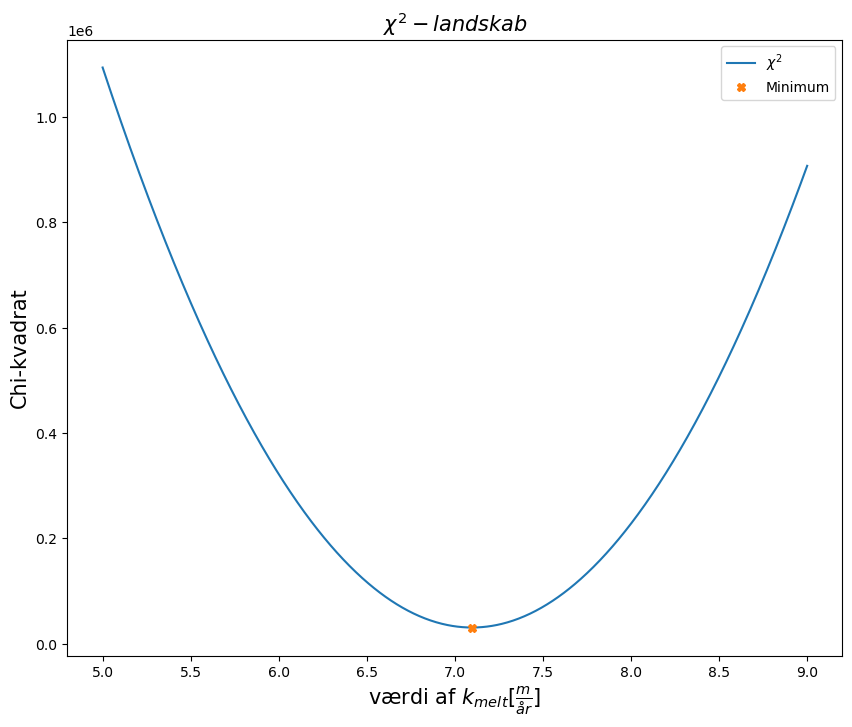

In [30]:
def optimering(gæt_start, gæt_slut, antal_forsøg):
    
    konstanter_list = np.linspace(gæt_start, gæt_slut, antal_forsøg)

    chi_list = []
    chi_red_list = []
    for konstant in konstanter_list:
        chi, chi_red = simulering(temp, konstant)
        chi_list.append(chi)
        chi_red_list.append(chi_red)
    
    optimal_k_melt_index = np.argmin(chi_list)

    print('Optimale k_melt-værdi =', konstanter_list[optimal_k_melt_index], 'm/år')
    print('index =', chi_list[optimal_k_melt_index])
    print('chi-kvadrat = ', chi_list[optimal_k_melt_index])
    print('reduceret chi_kvadrat =', chi_red_list[optimal_k_melt_index])

    plt.figure(figsize = (10,8))
    plt.title('$\chi^2 - landskab$', fontsize = 15)
    plt.plot(konstanter_list, chi_list, label = '$\chi^2$')
    plt.xlabel(r'værdi af $k_{melt} [\frac{m}{år}]$', fontsize = 15)
    plt.ylabel('Chi-kvadrat', fontsize = 15)
    plt.plot(konstanter_list[optimal_k_melt_index], chi_list[optimal_k_melt_index], 'X', label = 'Minimum')
    plt.legend()
    
    return konstanter_list, chi_list, chi_red_list, optimal_k_melt_index


# Jeg kører funktionen
konstanter_list, chi_list, chi_red_list, optimal_k_melt_index  = optimering(5, 9, 1000)


### Usikkerhed på $k_{melt}$ <br>
Jeg forsøger at sige noget om usikkerheden på k_melt ved at undersøge intervallet for $k_{melt}$, der tilsvarer [optimale $\chi^2$,optimale $\chi^2$ + 1 ]. Det viser sig, at usikkerheden på parameteren bliver helt utrolig lille med denne metode ... 

In [31]:
top = chi_list[optimal_k_melt_index] + 1

for i in range(len(chi_list)):
    if chi_list[i] < top:
        k_min =konstanter_list[i]
        break
for i in range(1, len(chi_list) + 1):
    if chi_list[-i] < top:
        k_max = konstanter_list[-i]
        break

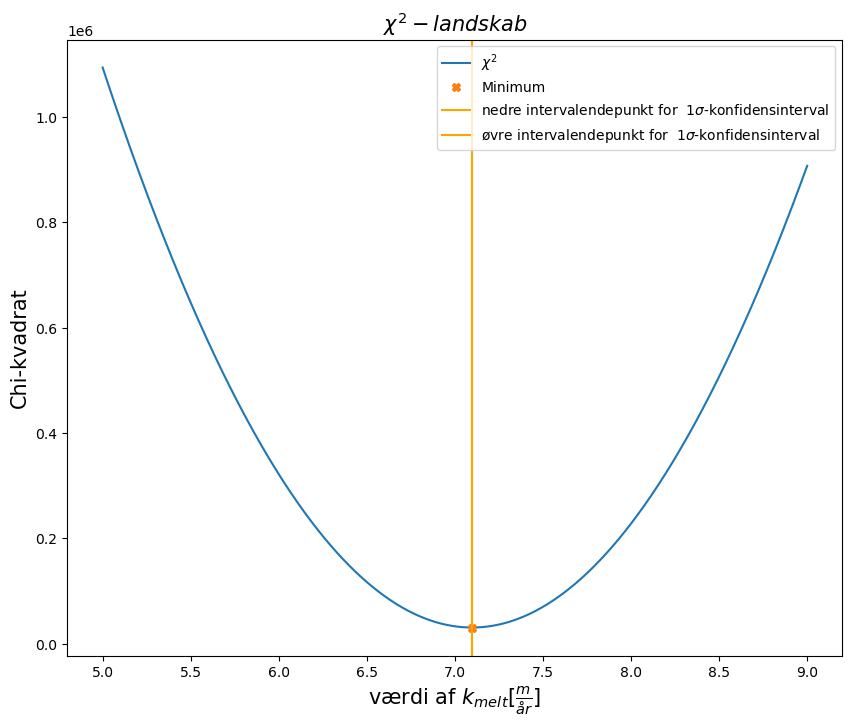

In [32]:
plt.figure(figsize = (10,8))
plt.title('$\chi^2 - landskab$', fontsize = 15)
plt.plot(konstanter_list, chi_list, label = '$\chi^2$')
plt.xlabel(r'værdi af $k_{melt} [\frac{m}{år}]$', fontsize = 15)
plt.ylabel('Chi-kvadrat', fontsize = 15)
plt.plot(konstanter_list[optimal_k_melt_index], chi_list[optimal_k_melt_index], 'X', label = 'Minimum')
plt.axvline(k_min, color = 'orange', label = 'nedre intervalendepunkt for  $1\sigma$-konfidensinterval')
plt.axvline(k_max, color = 'orange', label = 'øvre intervalendepunkt for  $1\sigma$-konfidensinterval')
#plt.axhline(chi_list[optimal_k_melt_index] + 1)
plt.legend()

## __Plot af simulering med optimale værdi af k_melt__

Her køres simuleringen baglæns med den optimale k-værdi, og model sammenlignes med data i et plot.

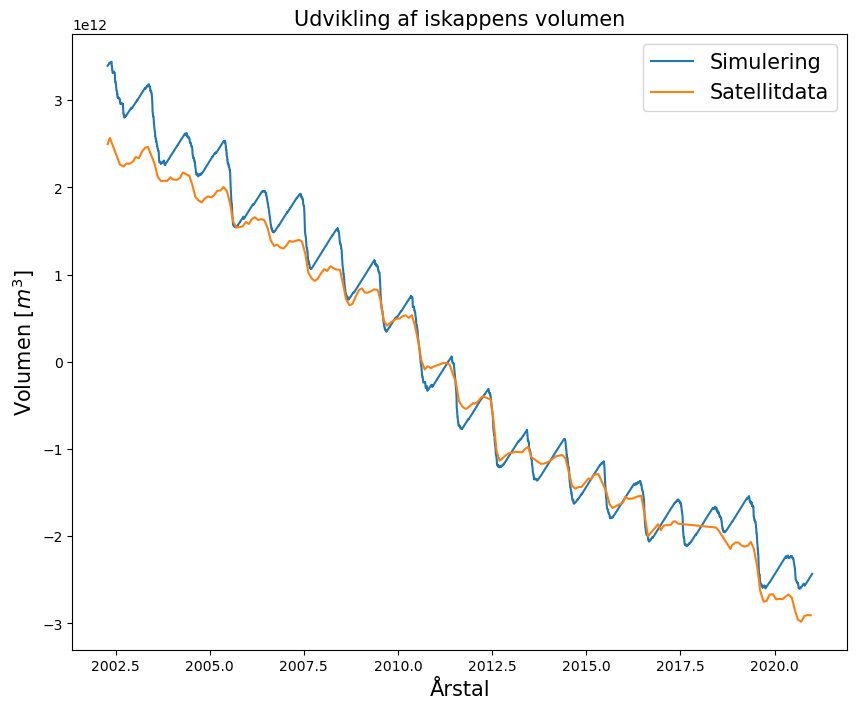

In [33]:
# De globale konstanter defineres
V_0 = 2.85 * 10**15
V = 2.85 * 10**15   # startvolumen af iskappe
h = 3 * 10**3       # Starthøjde af iskappe
R = 500 * 10**3     # Startradius af iskappe
T_f = 0        
alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
dt = 1/(365.25 * 4)  # Tidsskridt (her 1/2 døgn) - omregnet til år

# Tuningskonstanter
k_melt = konstanter_list[optimal_k_melt_index]  
acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden


# Der oprettes tomme lister til resultatet af simuleringen
V_list = []
V_melt_list = []
V_acc_list = []


for i in range(1, len(år) + 1):
    R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
    
    V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
    
    if temp[-i] - T_f <= 0:
        V_melt = 0 
    elif temp[-i] - T_f > 0:
        V_melt = k_melt * 8/3 * R * (temp[-i] - T_f) * ((T_f - temp[-i])/(alfa * k))**2 * dt # ganger tidsskridt og M på
    V +=  - V_acc + V_melt
    
    V_list.append(V)
    V_melt_list.append(V_melt)
    V_acc_list.append(V_acc)

V_list.reverse()
dvol_sim = V_list - np.mean(V_list)
    
# Plot
    
plt.figure(figsize = (10,8))
plt.plot(år , dvol_sim, label = 'Simulering')
plt.xlabel('Årstal', fontsize = 15)
plt.ylabel(r'Volumen $[m^3]$', fontsize = 15)
plt.title('Udvikling af iskappens volumen', fontsize = 15)

plt.plot(år_sat, dvol_sat_korr, label = 'Satellitdata')
plt.legend(fontsize = 15)
plt.savefig('Tuning af smeltekonstant.png')
